# 1. Mount and import library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Dataset/kkbox')

#2. Random Forest Implementation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
import re
import random
from sklearn import preprocessing
import gc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
from function import *

In [ ]:
# Import data 
data = pd.read_csv("/content/drive/MyDrive/Dataset/kkbox/processed_kkbox.csv")

# 3. Feature selection based on previous attempt in LightGBM



In [ ]:
'''import sklearn
import lightgbm as lgb
import sys 
print("System version: {}".format(sys.version))
print('LightGBM version: {}'.format(lgb.__version__))
print('RandomForest version: {}'.format(sklearn.__version__))'''

In [ ]:
#Delete the features based on importance score (<10) and re-run it （feature selection）
data.drop(['registration_date',
            'registered_via',
            'expiration_date',
            'registration_month',
            'city',            
            'registration_year',
            'song_lang_boolean',
            'song_length',
            'gender',
            'composer_count',
            'genre_ids_count',
            'is_featured',
            'artist_count',
            'artist_composer',
            'artist_composer_lyricist',
            'smaller_song',
            'lyricists_count' ], axis = 1, inplace = True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 18 columns):
 #   Column               Dtype  
---  ------               -----  
 0   msno                 object 
 1   song_id              object 
 2   source_system_tab    object 
 3   source_screen_name   object 
 4   source_type          object 
 5   target               int64  
 6   genre_ids            object 
 7   artist_name          object 
 8   composer             object 
 9   lyricist             object 
 10  language             float64
 11  bd                   float64
 12  membership_days      int64  
 13  expiration_year      int64  
 14  expiration_month     int64  
 15  song_year            float64
 16  count_song_played    float64
 17  count_artist_played  float64
dtypes: float64(5), int64(4), object(9)
memory usage: 1013.1+ MB


In [ ]:
# Imputing continuous columns
na_continuous_col = ['language',
                     'bd',
                     'membership_days',
                     'expiration_year',
                     'expiration_month',
                     'song_year',
                     'count_song_played',
                     'count_artist_played']
for col in na_continuous_col:
    data[col] = data[col].fillna(-1)

In [ ]:
# Imputing categorical columns
data = data.fillna('Not')

Label encoding

In [ ]:
# Label encoding for the categorical varaibles 
from sklearn import preprocessing
def encoder(x_train):
    le = preprocessing.LabelEncoder()
    for column_name in x_train.columns:
            if x_train[column_name].dtype.name in ['category','object']:
                x_train[column_name] = le.fit_transform(
                    x_train[column_name].astype(str))

# Encode the data
encoder(data)

Train Test Split

In [ ]:
# Features and target varaibles
X = data.drop(columns='target',axis=1)
y = data['target']

# Train and test split
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, 
                                                            test_size=0.2, random_state=1)

# Train and validation split
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, 
                                                  test_size=0.2, random_state=1)

In [ ]:
del data
gc.collect()

In [ ]:
# Sampled train data 
random.seed(130)
idx = random.sample(range(0,X_train.shape[0]), 1000000)
X_train_sampled = X_train.iloc[idx]
y_train_sampled = y_train.iloc[idx]

# 4. Grid Search (Best hyperparameters)

In [ ]:
# Pipeline and grid search
pipe_dt = Pipeline([('clf', RandomForestClassifier(n_jobs=-1))]) 

grid_params = dict(clf__n_estimators = [200,400],
                  clf__max_features = ['sqrt', 'log2'],
                  clf__min_samples_split = [20,40],
                   clf__max_depth = [30])

gs = GridSearchCV(estimator=pipe_dt,  
                  param_grid=grid_params,
                  scoring='accuracy',
                  cv=5)

gs.fit(X_train_sampled, y_train_sampled.ravel())
f"{gs.score(X_test, y_test):.4f}"

'0.6683'

In [ ]:
# Best algorithm with best hyperparameters 
# need to fit it to find specific model parameters
print(gs.best_estimator_)

Pipeline(steps=[('clf',
                 RandomForestClassifier(max_depth=30, max_features='log2',
                                        min_samples_split=20, n_estimators=400,
                                        n_jobs=-1))])


In [ ]:
gs.best_estimator_.get_params()['clf']

# 5. Best model


In [ ]:
#fit in the GridSearch output
m = RandomForestClassifier(n_estimators=400, n_jobs=-1,oob_score=False,
                           max_features='sqrt', min_samples_split= 20,max_depth = 20)
m.fit(X_train, y_train.ravel())
# Val accuracy
predicted = m.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score validation: {accuracy:.3}')# 20 depth 3000000

Mean accuracy score validation: 0.672


In [ ]:
# Test accuracy
predicted = m.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Mean accuracy score test: {accuracy:.3}')

Mean accuracy score test: 0.672


In [ ]:
depths = [tree.tree_.max_depth for tree in m.estimators_]
print(f"Mean tree depth in the Random Forest: {np.round(np.mean(depths))}") #58

Mean tree depth in the Random Forest: 20.0


# 6. Evaluation Metric

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_test, predicted)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.69031222 0.65701183]
recall: [0.6136557  0.72886671]
fscore: [0.64973075 0.6910765 ]
support: [732119 743365]


Confusion matrix, without normalization
[[449269 282850]
 [201551 541814]]
Normalized confusion matrix
[[0.61 0.39]
 [0.27 0.73]]


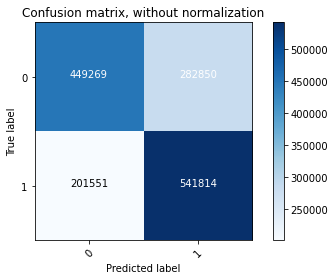

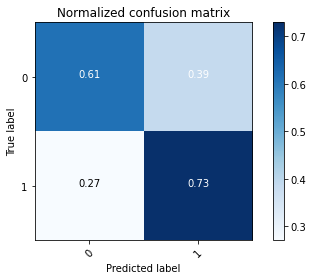

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
class_names = ['0','1']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]),
                                  range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
pd.DataFrame(predicted, columns=['rf']
            ).to_csv('rf_test_score.csv',index=False)

ROC Curve

In [ ]:
# Predict probability for ROC curve
predicted = m.predict_proba(X_test)

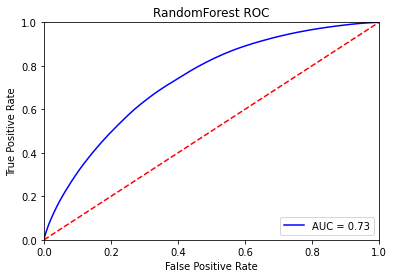

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random

false_positive_rate, true_positive_rate, thresholds = roc_curve(
    y_test, [i[1] for i in predicted])
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('RandomForest ROC')
plt.plot(false_positive_rate, true_positive_rate, 
         'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
